In [2]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import io
import os
import re
import string
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (
  Embedding,Input,LSTM,Input,Conv2D,Softmax,Dropout,Dense,GRU,
  MaxPooling2D,LayerNormalization,Reshape,BatchNormalization,Bidirectional)
from tensorflow.keras.optimizers import Adam

In [3]:
print('Tensorflow => ',tf.__version__)
print('Keras      => ',tf.keras.__version__)
print('Numpy      => ',np.__version__)

Tensorflow =>  2.10.0
Keras      =>  2.10.0
Numpy      =>  1.25.2


In [4]:
gpus = tf.config.list_physical_devices('GPU')
gpus[0]
tf.config.experimental.set_memory_growth(gpus[0], True)

In [5]:
#####################################################################
# RUN THIS CODE CELL IF YOU ARE RESUMING THE NOTEBOOK AFTER A BREAK #
#####################################################################

# allocate 50% of GPU memory (if you like, feel free to change this)
#import requests
from keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
set_session(tf.compat.v1.Session(config=config))

# watch for any changes in the sample_models module, and reload it automatically
%load_ext autoreload
%autoreload 2

In [6]:
BATCH_SIZE=8
LR=1e-4
FRAME_LENGTH=255
FRAME_STEP=128
N_EPOCHS=100

# Tamil Male

## Data Visualization

In [7]:
audio_binary=tf.io.read_file("D:/CDAC/Datasets/IndicTTS/IndicTTS_Phase2_Tamil_male_Speaker1_english/english/wav/train_tamilmale_00001.wav")
audio,_=tf.audio.decode_wav(audio_binary)
waveform=tf.squeeze(audio,axis=-1)
waveform=tf.cast(waveform,tf.float32)
signal=waveform
print(signal.shape)

(206877,)


(206877,)


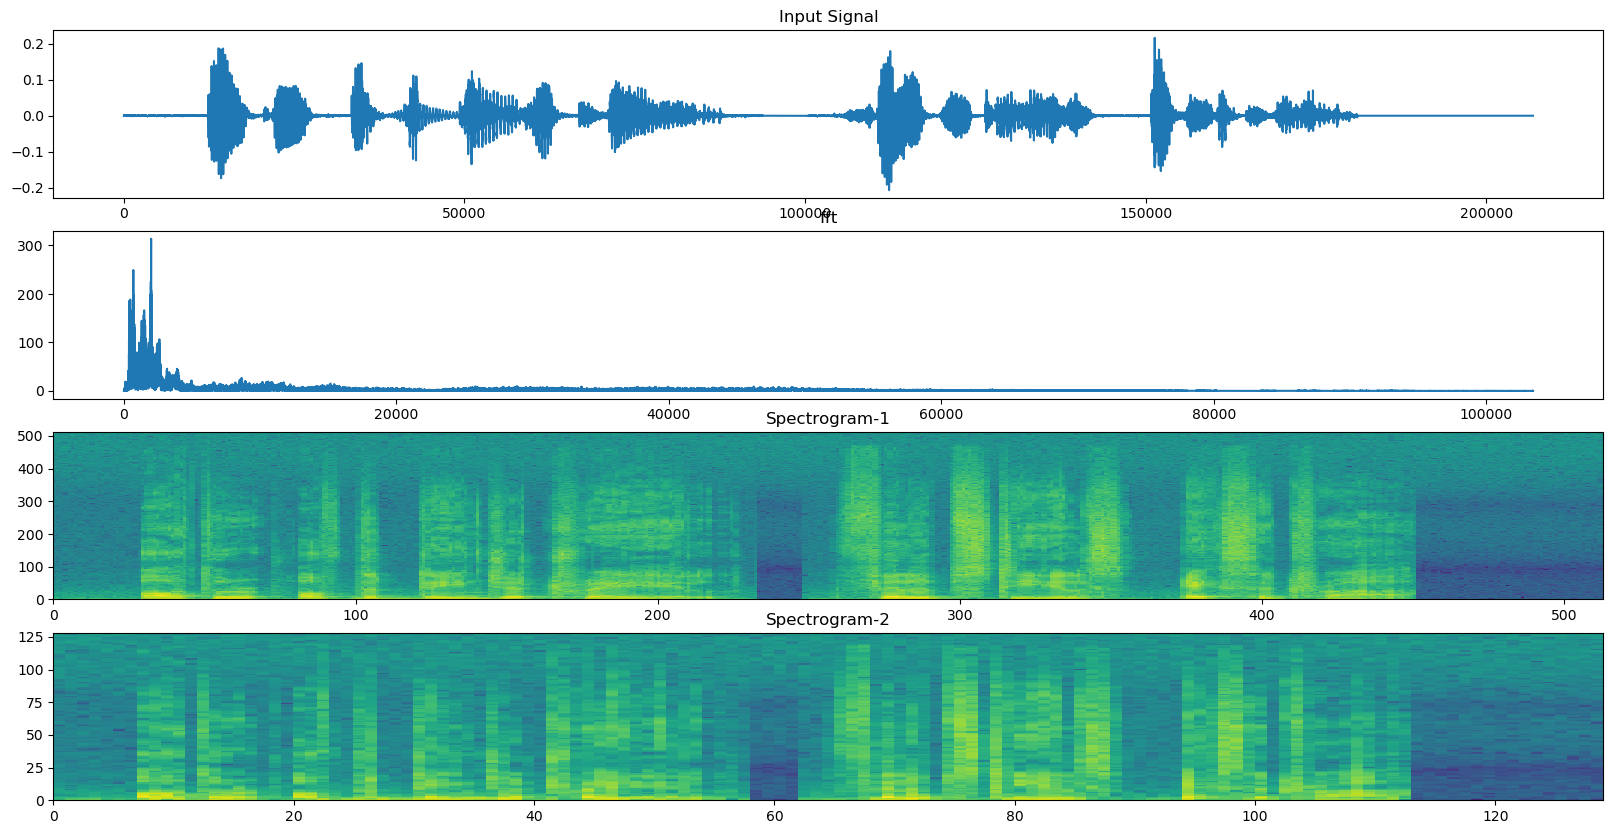

In [8]:
fig,axis=plt.subplots(4,figsize=(20,10))

L=2000
x=tf.linspace(-L//2,L//2,L)
print(signal.shape)
axis[0].plot(signal)
axis[0].set_title("Input Signal")

fft=tf.signal.rfft(signal)

axis[1].plot(tf.abs(fft))
axis[1].set_title("fft")


spec=tf.signal.stft(signal,frame_length=1024,frame_step=512,)
spec=tf.transpose(tf.abs(spec),[1,0])

power_spec=np.log(spec)
height=power_spec.shape[0]

width=power_spec.shape[1]

X=np.linspace(0,power_spec.shape[0],num=width,dtype=int)
Y=range(height)

axis[2].pcolormesh(X,Y,power_spec)
axis[2].set_title("Spectrogram-1")


spec=tf.signal.stft(signal,frame_length=256,frame_step=128, )
spec=tf.transpose(tf.abs(spec),[1,0])

power_spec=np.log(spec)
height=power_spec.shape[0]

width=power_spec.shape[1]

X=np.linspace(0,power_spec.shape[0],num=width,dtype=int)
Y=range(height)

axis[3].pcolormesh(X,Y,power_spec)
axis[3].set_title("Spectrogram-2")


plt.show()


## Data Preparation

In [9]:
audio_text2={}
csv_path="D:/CDAC/Datasets/IndicTTS/IndicTTS_Phase2_Tamil_male_Speaker1_english/english/txt.done.data"
with open(csv_path, encoding="utf-8") as f:
  for line in f:
    i=line.strip().split(" \" ")[0].removeprefix("( ")    
    text=line.strip().split(" \" ")[1].removesuffix(' " )')    
    audio_text2[str(i)]=text    

audio_text2

{'train_tamilmale_00001': 'Author of the danger trail, Philip Steels, etc.',
 'train_tamilmale_00002': 'Not at this particular case, Tom, apologized Whittemore.',
 'train_tamilmale_00003': 'For the twentieth time that evening the two men shook hands.',
 'train_tamilmale_00004': "Lord, but I'm glad to see you again, Phil.",
 'train_tamilmale_00005': 'Will we ever forget it.',
 'train_tamilmale_00006': "God bless 'em, I hope I'll go on seeing them forever.",
 'train_tamilmale_00007': 'And you always want to see it in the superlative degree.',
 'train_tamilmale_00008': 'Gad, your letter came just in time.',
 'train_tamilmale_00009': 'He turned sharply, and faced Gregson across the table.',
 'train_tamilmale_00010': "I'm playing a single hand in what looks like a losing game.",
 'train_tamilmale_00011': 'If I ever needed a fighter in my life I need one now.',
 'train_tamilmale_00012': 'Gregson shoved back his chair and rose to his feet.',
 'train_tamilmale_00013': 'He was a head shorter th

In [10]:
filepaths=["D:/CDAC/Datasets/IndicTTS/IndicTTS_Phase2_Tamil_male_Speaker1_english/english/wav/"+filename+".wav" for filename in list(audio_text2.keys())]
transcriptions=[audio_text2[str(filename)].lower() for filename in list(audio_text2.keys())]
print(len(filepaths))
print(len(transcriptions))

7547
7547


In [11]:
dataset=tf.data.Dataset.from_tensor_slices((filepaths,transcriptions))

for i in dataset.take(1):
  print(i)

(<tf.Tensor: shape=(), dtype=string, numpy=b'D:/CDAC/Datasets/IndicTTS/IndicTTS_Phase2_Tamil_male_Speaker1_english/english/wav/train_tamilmale_00001.wav'>, <tf.Tensor: shape=(), dtype=string, numpy=b'author of the danger trail, philip steels, etc.'>)


In [12]:
def decode_audio(audio_binary):
    audio,_=tf.audio.decode_wav(audio_binary)
    return tf.squeeze(audio,axis=-1)

In [13]:
vocabulary=[""]+[chr(i) for i in range(97,97+26)]+[".",",","?"," "]
print(vocabulary)
print(len(vocabulary))

['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '.', ',', '?', ' ']
31


In [14]:
def get_label(label,):
    label=tf.strings.unicode_split(label, input_encoding="UTF-8")
    label=tf.keras.layers.StringLookup(vocabulary=vocabulary, oov_token="")(label)
    return label

In [15]:
def get_spec(filepath,label):

  audio_binary=tf.io.read_file(filepath)
  waveform=decode_audio(audio_binary)
  waveform=tf.cast(waveform,tf.float32)

  spectrogram=tf.signal.stft(
      waveform,frame_length=FRAME_LENGTH,frame_step=FRAME_STEP)
  spectrogram=tf.abs(spectrogram)
  label=get_label(label)
  return tf.expand_dims(spectrogram,axis=-1),label

In [16]:
processed_dataset = (
    dataset.map(get_spec, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [17]:
train_dataset=processed_dataset.take(int(0.95*len(processed_dataset)))
val_dataset=processed_dataset.skip(int(0.95*len(processed_dataset)))

In [18]:
for i,j in train_dataset.take(1):
  print(i,j)

tf.Tensor(
[[[[4.5057666e-02]
   [2.6624223e-02]
   [7.0914123e-03]
   ...
   [1.9697491e-03]
   [1.0783451e-03]
   [4.9040839e-04]]

  [[4.4271640e-02]
   [2.3623243e-02]
   [6.0108644e-03]
   ...
   [5.4431957e-04]
   [6.3586363e-04]
   [2.0544231e-04]]

  [[4.8904503e-03]
   [1.1373784e-02]
   [1.9258641e-03]
   ...
   [4.3013456e-04]
   [1.2674734e-04]
   [4.1473634e-04]]

  ...

  [[0.0000000e+00]
   [0.0000000e+00]
   [0.0000000e+00]
   ...
   [0.0000000e+00]
   [0.0000000e+00]
   [0.0000000e+00]]

  [[0.0000000e+00]
   [0.0000000e+00]
   [0.0000000e+00]
   ...
   [0.0000000e+00]
   [0.0000000e+00]
   [0.0000000e+00]]

  [[0.0000000e+00]
   [0.0000000e+00]
   [0.0000000e+00]
   ...
   [0.0000000e+00]
   [0.0000000e+00]
   [0.0000000e+00]]]


 [[[1.2195960e-06]
   [1.9780842e-05]
   [3.2491287e-05]
   ...
   [1.1302747e-03]
   [2.6096817e-04]
   [5.7676027e-04]]

  [[8.8606030e-06]
   [2.5474297e-05]
   [2.3522542e-05]
   ...
   [1.8878777e-03]
   [1.7258463e-03]
   [1.0494373e-03

## Modeling 

In [19]:
normalization=tf.keras.layers.Normalization()

In [20]:
input_spectrogram=Input((None,129,1), name="input")

x=normalization(input_spectrogram)
x=Conv2D(32,kernel_size=[11,41],strides=[2,2],padding='same',activation='relu')(x)
x=LayerNormalization()(x)
x=Conv2D(64,kernel_size=[11,21],strides=[1,2],padding='same',activation='relu')(x)
x=LayerNormalization()(x)

x=Reshape((-1, x.shape[-2] * x.shape[-1]))(x)

x=Bidirectional(GRU(128,return_sequences=True))(x)
x=Bidirectional(GRU(128,return_sequences=True))(x)
x=Bidirectional(GRU(128,return_sequences=True))(x)


output=Dense(len(vocabulary)+1, activation="softmax")(x)

model = tf.keras.Model(input_spectrogram, output, name="DeepSpeech_2_Inspired")
model.summary()

Model: "DeepSpeech_2_Inspired"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, None, 129, 1)]    0         
                                                                 
 normalization (Normalizatio  (None, None, 129, 1)     3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, None, 65, 32)      14464     
                                                                 
 layer_normalization (LayerN  (None, None, 65, 32)     64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, None, 33, 64)      473152    
                                                                 
 layer_normalization_1 (Laye  (None, None, 33

In [21]:
def ctc_loss(y_true,y_pred):
  batch_size=tf.shape(y_pred)[0]
  pred_length=tf.shape(y_pred)[1]
  true_length=tf.shape(y_true)[1]

  pred_length=pred_length*tf.ones([batch_size,1],dtype=tf.int32)
  true_length=true_length*tf.ones([batch_size,1],dtype=tf.int32)

  return tf.keras.backend.ctc_batch_cost(y_true,y_pred,pred_length,true_length)

In [22]:
model.compile(
    loss=ctc_loss,
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
)

In [24]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("ASR_IndicTTS_Tamil_Male_Model-{epoch:03d}.h5")
model_path='D:/CDAC/Project/ASR-using-deepspeech2/ASR_IndicTTS_Tamil_Male_Model_Final.h5'

## Training

In [ ]:
history=model.fit(
  train_dataset,
  validation_data=val_dataset,
  verbose=1,
  epochs=N_EPOCHS,  
  callbacks=[checkpoint_cb]  
)

Epoch 1/100
896/896 [==============================] - 2147s 2s/step - loss: 248.3710 - val_loss: 269.2503
Epoch 2/100
896/896 [==============================] - 804s 898ms/step - loss: 183.6272 - val_loss: 182.2858
Epoch 3/100
896/896 [==============================] - 848s 947ms/step - loss: 127.6862 - val_loss: 137.6602
Epoch 4/100
896/896 [==============================] - 856s 956ms/step - loss: 101.1012 - val_loss: 114.8292
Epoch 5/100
896/896 [==============================] - 854s 954ms/step - loss: 86.2473 - val_loss: 103.5717
Epoch 6/100
896/896 [==============================] - 830s 926ms/step - loss: 77.0711 - val_loss: 97.0002
Epoch 7/100
896/896 [==============================] - 854s 953ms/step - loss: 70.4166 - val_loss: 92.6174
Epoch 8/100
896/896 [==============================] - 868s 969ms/step - loss: 65.0046 - val_loss: 89.5885
Epoch 9/100
896/896 [==============================] - 847s 945ms/step - loss: 60.4204 - val_loss: 87.6677
Epoch 10/100
896/896 [========

In [ ]:
# save model
model.save(model_path)

## Testing

In [42]:
#obtain and decode the acoustic model's predictions
model.load_weights(model_path)

In [43]:
def get_spec_inference(filepath):

  audio_binary=tf.io.read_file(filepath)
  waveform=decode_audio(audio_binary)
  waveform=tf.cast(waveform,tf.float32)

  spectrogram=tf.signal.stft(
      waveform,frame_length=FRAME_LENGTH,frame_step=FRAME_STEP)

  spectrogram=tf.abs(spectrogram)

  return tf.expand_dims(spectrogram,axis=-1)

In [44]:
def decode(y_pred):
  batch_size=tf.shape(y_pred)[0]
  print(tf.shape(y_pred))

  pred_length=tf.shape(y_pred)[1]
  pred_length*=tf.ones([batch_size,],dtype=tf.int32)

  y_pred=tf.one_hot(y_pred,len(vocabulary)+1)
  output=tf.keras.backend.ctc_decode(y_pred,input_length=pred_length,greedy=True)[0][0]

  out=[vocabulary[i] for i in output[0]]
  return ''.join(out)

In [45]:
test_path="D:/CDAC/Datasets/IndicTTS/IndicTTS_Phase2_Tamil_male_Speaker1_english/english/wav/train_tamilmale_00220.wav"
from IPython.display import Audio
# play the audio file
Audio(test_path)

In [46]:
spectrogram=get_spec_inference(test_path)
print(spectrogram.shape)
out=tf.argmax(model.predict(tf.expand_dims(spectrogram,axis=0))[0],axis=1)
out

(1326, 129, 1)
1/1 [==============================] - 0s 229ms/step


<tf.Tensor: shape=(663,), dtype=int64, numpy=
array([31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31,
       31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31,
       31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31,
       31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31,
       31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31,
       31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31,
       31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31,
       23, 23, 23, 23, 23,  8,  8,  8,  8,  8,  8, 31, 31, 31, 31, 31, 31,
       31, 31, 31, 31, 31, 31,  1,  1, 31, 31, 31, 20, 20, 20, 20, 31, 31,
       31, 31, 31, 31, 31, 31, 31, 31, 30, 30, 30, 16, 31, 31, 31, 31, 31,
       31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31,
       31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31,
       31, 31, 31, 31,  1, 18, 18, 18, 20, 20, 30, 30,

In [47]:
out_list=[vocabulary[i] if i!=31 else "[LINK]" for i in out]
out_str="".join(out_list)
print(out_str)

[LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK]wwwwwhhhhhh[LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK]aa[LINK][LINK][LINK]tttt[LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK]   p[LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][

In [49]:
print(decode(tf.expand_dims(out,axis=0)))

tf.Tensor([  1 663], shape=(2,), dtype=int32)
what part of the united states is your home.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
